# Semi-supervised anomaly detection - Spectral centroid

This notebook will show how to create an AE model with the [spectral centroid](https://en.wikipedia.org/wiki/Spectral_centroid) of the audio samples. Although most AE models for audios use 2D audio features (spectrogram, mel-spectrogram...), 1D audio features can be used too.

# Libraries

Let's load the libraries for this notebook.
- **Tensorflow dataset** to load the dataset
- **Tensorflow** to create an AE model
- **Pandas** to manipulate results
- **Sklearn** to compute metrics
- **Plotnine** to plot results

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras.layers import (
    InputLayer,
    Dense,
    BatchNormalization,
    Activation,

)
from tensorflow.keras import Sequential

import numpy as np
import pandas as pd

import sklearn
from sklearn.metrics import (
    confusion_matrix, 
    classification_report,
    roc_auc_score
)

import plotnine as p9

import datetime

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(f"Tensorflow datasets: {tfds.__version__}")
print(f"Tensorflow: {tf.__version__}")
print(f"Sklearn: {sklearn.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Plotnine: {p9.__version__}")

Tensorflow datasets: 4.2.0
Tensorflow: 2.4.1
Sklearn: 0.24.2
Numpy: 1.19.5
Pandas: 1.2.4
Plotnine: 0.8.0


Let's set the seed for the Tensorflow dataset.

In [3]:
config = tfds.ReadConfig(try_autocache=True, shuffle_seed=42)

## Dataset

Let's load the dataset and create three sets (train, validation, test). We make the train set (90%) and validation set (10%) from the train data and the test set from the test data. 

In [4]:
import pump
data_dir = "../dataset"

(train, val, test), info = tfds.load(
    "pump",
    split=["train[:90%]", "train[90%:]", "test"],
    data_dir=data_dir,
    with_info=True,
    shuffle_files=True,
    read_config=config,
)

## Feature extraction

Let's extract the audio feature for the AE model.

To get the spectral centroid of the audios, we need to:
- Calculate the magnitude from the STFT of the audio sample with an analysis frame of 64ms and 50% hop size.
- Calculate the spectral centroid:

![spectral centroid](https://wikimedia.org/api/rest_v1/media/math/render/svg/0a62c839a6ceafd854138264d81b2986d8cdaff1)

In [5]:
def spectral_centroid(item):
    audio = tf.cast(item["audio"], dtype = tf.float32)
    audio = audio / 2**15
    audio = tf.signal.stft(audio, frame_length=1024, frame_step=512)
    audio = tf.abs(audio)
    freqs = tf.constant(np.arange(0,513), dtype=audio.dtype)
    item["audio"] = tf.reduce_sum(audio * freqs, axis=1) / tf.reduce_sum(audio, axis=1)
    return item

Let's prepare the sets for training. AE models need that the input and the output be the same.

In [6]:
def prep_train(item):
    return item["audio"], item["audio"]

In [7]:
BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 1024

train = train.map(spectral_centroid)
train2 = train.map(prep_train).batch(BATCH_SIZE)

val = train.map(spectral_centroid)
val2 = train.map(prep_train).batch(BATCH_SIZE)

test = test.map(spectral_centroid)
test2 = test.batch(BATCH_SIZE)

## Training

Let's create an simple AE model. 

![AE model](https://d1jnx9ba8s6j9r.cloudfront.net/blog/wp-content/uploads/2018/10/Autoencoders-528x265.png)

In [8]:
autoencoder = Sequential(
    [
        InputLayer(input_shape=311),
        BatchNormalization(),
        Dense(128),
        BatchNormalization(),
        Activation('elu'),
        Dense(32),
        BatchNormalization(),
        Activation('elu'),
        Dense(8),
        BatchNormalization(),
        Activation('elu'),
        Dense(32),
        BatchNormalization(),
        Activation('elu'),
        Dense(128),
        BatchNormalization(),
        Activation('elu'),
        Dense(311, activation=None),
    ]
)

autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 311)               1244      
_________________________________________________________________
dense (Dense)                (None, 128)               39936     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0

We can use [rmsprop](https://optimization.cbe.cornell.edu/index.php?title=RMSProp) as the optimizer and the [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) as the loss function. 

In [9]:
autoencoder.compile(optimizer='rmsprop', loss='mse')

Let's create a Tensorboard callback to check the results in Tensorboard and a ModelCheckpoint callback to save the best model.

In [10]:
log_dir = os.path.join('..', 'logs', 'semi-centroid', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir, update_freq=1, histogram_freq=1, write_graph=True
)

In [11]:
checkpoint_filepath = os.path.join("tmp", "semi-centroid", "checkpoint")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

AE models needs that the input and the output be same.

In [12]:
history = model.fit(
    train2,
    epochs=50,
    shuffle=True,
    validation_data=val2,
    callbacks=[tb_callback, model_checkpoint_callback],
    verbose=1,
)

Epoch 1/50
12/12 [==============================] - 58s 5s/step - loss: 19114.8274 - val_loss: 17746.3496
Epoch 2/50
12/12 [==============================] - 53s 5s/step - loss: 18848.9563 - val_loss: 18444.8105
Epoch 3/50
12/12 [==============================] - 53s 5s/step - loss: 18673.2357 - val_loss: 18220.5195
Epoch 4/50
12/12 [==============================] - 52s 5s/step - loss: 18513.2046 - val_loss: 18077.8965
Epoch 5/50
12/12 [==============================] - 50s 4s/step - loss: 18383.4273 - val_loss: 17678.0996
Epoch 6/50
12/12 [==============================] - 50s 4s/step - loss: 18269.7270 - val_loss: 16903.7207
Epoch 7/50
12/12 [==============================] - 51s 4s/step - loss: 17766.8459 - val_loss: 17004.1523
Epoch 8/50
12/12 [==============================] - 53s 5s/step - loss: 17630.9740 - val_loss: 16243.7891
Epoch 9/50
12/12 [==============================] - 54s 5s/step - loss: 17371.6164 - val_loss: 15437.8301
Epoch 10/50
12/12 [===========================

## Testing

Let's join train and test set together for faster predictions.

In [13]:
audios = train.concatenate(test)

In [14]:
pred = autoencoder.predict(audios.map(lambda item: item["audio"]).batch(BATCH_SIZE))

Let's compute the reconstruction error for all audios.

In [15]:
error_lst = []
for item, pred in zip(tfds.as_numpy(audios), pred):
    error = np.mean(np.square(item["audio"] - pred))
    error_lst.append(error)

To check how the model behaves, we can tranform the Tensorflow dataset into a dataframe and add the previous computed reconstruction error to it.

In [16]:
audios_df = tfds.as_dataframe(audios, info)

# Convert byte-type texts to string-type texts
for col in audios_df:
    if isinstance(audios_df[col][0], bytes):
        audios_df[col] = audios_df[col].str.decode("utf8")

dct_columns = {
    "audio/id": "id", 
    "audio/machine": "machine_id", 
    "audio/split": "split",
}

# Convert object-type columns to a more convenient data type
dct_types = {
    "id": "string",
    "machine_id": "category",
    "split": "category",
    "label": "category",
}

audios_df = (
    audios_df
    .rename(columns=dct_columns)
    .astype(dct_types)
)

audios_df.sample(5)

,audio,id,machine_id,split,label
34,"[82.65166, 87.10631, 89.10159, 83.11982, 72.39...",0620,06,0,0
108,"[79.278786, 81.464966, 85.8879, 75.704956, 82....",0859,06,0,0
89,"[163.02391, 166.22331, 152.43742, 162.5496, 16...",0235,06,0,0
2392,"[80.64358, 92.7993, 80.08966, 86.35512, 89.903...",0474,06,0,0
3159,"[154.89357, 118.82211, 130.7186, 121.424126, 1...",0061,00,1,1


In [17]:
audios_df["error"] = error_lst

In [18]:
audios_df.sample(5)

,audio,id,machine_id,split,label,error
2481,"[142.84335, 119.777824, 110.095375, 114.74232,...",0639,00,0,0,10081.697266
2403,"[124.90154, 124.564766, 127.15727, 111.01095, ...",0359,00,0,0,527.883545
426,"[131.17766, 109.735695, 135.25594, 111.5642, 1...",0130,06,0,0,7002.477539
903,"[149.08675, 150.34822, 145.53302, 149.88724, 1...",0530,02,0,0,2378.437012
2701,"[129.34178, 126.731445, 114.71663, 94.28266, 9...",0542,06,0,0,11056.921875


In [19]:
(
    audios_df
    .query("split == 0")
    .groupby("machine_id")
    .agg({"error": ["mean", "std"]})
)

error             
                   mean          std
machine_id                          
00          6827.635807  5390.965319
02          7137.638278  6058.576393
04          6816.458829  5621.367352
06          7007.463559  5559.776154

In [20]:
(
    audios_df
    .query("split == 1")
    .groupby(["label", "machine_id"])
    .agg({"error": ["mean", "std"]})
)

error             
                         mean          std
label machine_id                          
0     00          7863.843589  6790.610072
      02          6217.026346  5094.969100
      04          8046.304669  5815.120601
      06          6421.869716  5070.037393
1     00          6872.048815  5035.388590
      02          7931.859856  6811.182849
      04          7576.581340  5486.547814
      06          5688.099276  4452.068343

It seems this model can't distinguish anomaly sound from normal sounds very well.

Let's plot the a histogram of the construction error per machine to see more clear.

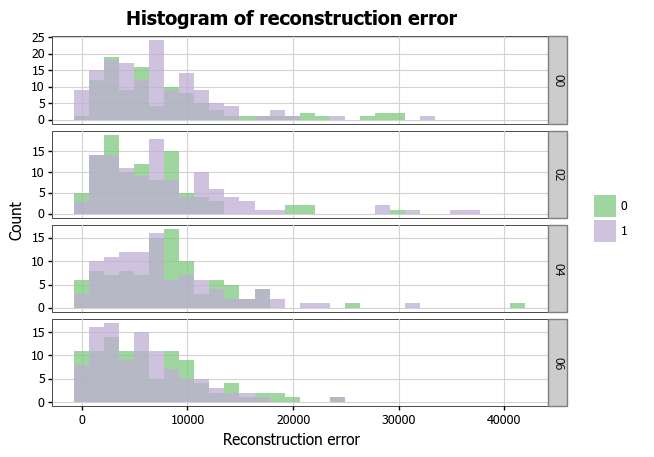

In [21]:
p = (
    p9.ggplot(audios_df.query("split == 1"), p9.aes(x="error", fill="label"))
    + p9.geom_histogram(
        p9.aes(y="stat(count)"), position="identity", alpha=0.75
    )
    + p9.scale_x_continuous(name="Reconstruction error")
    + p9.scale_y_continuous(name="Count")
    + p9.labs(
        title="Histogram of reconstruction error",
    )
    + p9.scale_fill_brewer(type="qualitative", palette="Accent") 
    + p9.facet_grid("machine_id ~ .", scales="free")
    + p9.theme_bw()
    + p9.theme(
        panel_border=p9.element_rect(colour="black", fill=None, size=0.5),
        axis_text_x=p9.element_text(colour="black", size=9),
        axis_text_y=p9.element_text(colour="black", size=9),
        legend_key=p9.element_blank(),
        legend_title=p9.element_blank(),
        panel_grid_major=p9.element_line(colour="#d3d3d3"),
        panel_grid_minor=p9.element_blank(),
        panel_background=p9.element_blank(),
        plot_title=p9.element_text(size=14, family="Tahoma", face="bold"),
        text=p9.element_text(family="Tahoma"),
    )
)

print(p)

Histograms show more clear that the model can't differentiate anomaly audios from normal audio very well.

This [AWS](https://aws.amazon.com/es/blogs/machine-learning/performing-anomaly-detection-on-industrial-equipment-using-audio-signals/) post shows how the histogram from a good model should look like.

![Better model](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2020/12/22/ML-1479-4.jpg)

## Metrics

Let's see how bad our model is. To distinguish anomaly audios from normal audios, we set the threshold one standard deviation above the mean of the train set. 

In [22]:
avg = (
    audios_df
    .query("split == 0")
    ["error"]
    .mean()
)

std = (
    audios_df
    .query("split == 0")
    ["error"]
    .std()
)

threshold = avg + std

In [23]:
print(threshold)

12622.784071925013


Let's create a new column with the predicted label based on the threshold.

In [24]:
audios_df["label_pred"] = audios_df["error"] > threshold

audios_df = audios_df.astype({"label_pred": "int"})
audios_df.head()

,audio,id,machine_id,split,label,error,label_pred
0,"[103.06415, 107.74395, 100.87735, 99.36588, 10...",0784,06,0,0,5999.866699,0
1,"[121.727745, 122.398575, 117.00896, 114.22704,...",0215,02,0,0,26397.511719,1
2,"[105.83715, 95.27515, 101.53854, 102.32228, 96...",0918,06,0,0,6945.892090,0
3,"[106.25704, 111.14007, 94.80665, 99.206795, 10...",0033,06,0,0,9580.779297,0
4,"[115.84677, 108.69644, 101.92698, 124.113174, ...",0580,02,0,0,6252.775391,0


Let's show the precision, recall, f1-score and roc-auc score for the four machines.

### Machine_id=00

In [25]:
machine_id = "00"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 1")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.40      0.86      0.54       100
           1       0.46      0.08      0.14       143

    accuracy                           0.40       243
   macro avg       0.43      0.47      0.34       243
weighted avg       0.43      0.40      0.31       243



In [26]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[ 86  14]
 [131  12]]


In [27]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.4720


This model is so bad distinguishing sounds for this machine that tossing a coin can predict better. 

### Machine_id=02

In [28]:
machine_id = "02"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 1")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.49      0.93      0.65       100
           1       0.70      0.14      0.24       111

    accuracy                           0.52       211
   macro avg       0.60      0.54      0.44       211
weighted avg       0.60      0.52      0.43       211



In [29]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[93  7]
 [95 16]]


In [30]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.5371


This model is slightly better distinguishing sounds for this machine that tossing a coin. 

### Machine_id=04

In [31]:
machine_id = "04"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 1")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.50      0.83      0.62       100
           1       0.48      0.16      0.24       100

    accuracy                           0.49       200
   macro avg       0.49      0.49      0.43       200
weighted avg       0.49      0.49      0.43       200



In [32]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[83 17]
 [84 16]]


In [33]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.4950


This model is so bad distinguishing sounds for this machine that tossing a coin can predict better. 

### Machine_id=06

In [34]:
machine_id = "06"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 1")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.48      0.87      0.62       100
           1       0.38      0.08      0.13       102

    accuracy                           0.47       202
   macro avg       0.43      0.47      0.37       202
weighted avg       0.43      0.47      0.37       202



In [35]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[87 13]
 [94  8]]


In [36]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.4742


This model is so bad distinguishing sounds for this machine that tossing a coin can predict better. 

## Conclusions

This model doesn't help to distinguish anomaly sounds from normal audios. 